### NAO correlations with energy variables ###

Exploring how well the NAO correlates with energy variables on seasonal to decadal timescales during the winter (ONDJFM, DJFM, or DJF). Using the following datasets:

* CLEARHEADS - ERA5-derived energy time series, includes offshore wind in EEZs and Heating Degree Days.
* ERA5 - reanalysis product for deriving the NAO indices at different timescales.
* ENTSO-E - shorter observed time series of capacity factors and other energy variables. For ground truthing the CLEARHEADS data above.

In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import local modules
import sys
import os
import glob

# Import third-party modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import iris
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cdsapi
# import xesmf as xe
from datetime import datetime
from tqdm import tqdm
from scipy.stats import pearsonr

ERROR 1: PROJ: proj_create_from_database: Open of /apps/jasmin/jaspy/mambaforge_envs/jaspy3.10/mf-22.11.1-4/envs/jaspy3.10-mf-22.11.1-4-r20230718/share/proj failed


In [2]:
sys.path.append("/home/users/benhutch/energy-met-corr-functions")

# Import the semi-local functions
import functions_em as funcs_em

In [3]:
sys.path.append("/home/users/benhutch/energy-met-corr")
import dictionaries_em as dicts

sys.path.append("/home/users/benhutch/skill-maps/python")
import functions as fnc

sys.path.append("/home/users/benhutch/skill-maps")
import dictionaries as dicts_sm

### Aggregate correlations ###

Test the function for aggregating correlations for the dataframes.

In [4]:
# # Set up the list of filenames
# filenames = [
#     "solar_power_cfs_NUTS_obs_corr.csv",
#     "onshore_wp_NUTS0_obs_corr.csv",
#     "offshore_wp_EEZ_obs_corr.csv",
#     "HDD_NUTS_obs_corr.csv",
#     "corr_obs_nao_obs_pr_NUTS0.csv",
#     "corr_obs_delta_p_obs_pr_NUTS0.csv",
# ]

# # Set up the prefixes
# prefixes = [            
#     "solar_cfs",
#     "onshore_wp_cfs",
#     "offshore_wp_cfs",
#     "hdd",
#     "nao_pr",
#     "delta_p_pr",
# ]

In [5]:
# # Call the function
# df = funcs_em.merge_dfs_by_region(
#     dfs_dir="/home/users/benhutch/energy-met-corr/df",
#     filenames=filenames,
#     prefixes=prefixes,
# )

In [6]:
# dfs = funcs_em.calc_nao_region_corr(
#     shp_fname="NUTS_RG_10M_2021_4326.shp",
#     shp_fpath="/home/users/benhutch/shapefiles/NUTS/",
#     predictand_var_name="var228",
#     predictand_var_data_path=dicts.regrid_file_pr,
#     nao_n_grid=dicts.uk_n_box_corrected,
#     nao_s_grid=dicts.uk_s_box_corrected,
#     save_fname="corr_obs_delta_p_obs_pr_NUTS0.csv",
# )

In [7]:
# df = funcs_em.aggregate_obs_correlations(
#     uread_fname="NUTS_0_HDD_historical_pop_weighted.nc",
#     shp_fname="NUTS_RG_10M_2021_4326.shp",
#     shp_fpath="/home/users/benhutch/shapefiles/NUTS/",
#     obs_vars=[],
#     obs_var_data_paths=[],
#     obs_var_levels=[],
#     save_fname="pr_NUTS_obs_corr_indices.csv",
# )

### Testing mean stats function ###

In [8]:
# # And for the NUTS data
# df = funcs_em.plot_eu_clearheads(
#     file="NUTS_0_t2m_detrended_timeseries_historical_pop_weighted.nc",
#     shp_file="NUTS_RG_10M_2021_4326.shp",
#     shp_file_dir="/home/users/benhutch/shapefiles/NUTS/",
#     label="Pop. weighted temp (K)",
#     trend_level=2020.0,
# )

In [9]:
# # Test the function for plotting the winter mean state
# funcs_em.plot_winter_mean(
#     obs_var="si10",
#     obs_var_data_path=dicts.era5_msl_path,
#     cmap="Greys",
#     vmin=0,
#     vmax=10,
# )

In [10]:
# data = "/home/users/benhutch/CLEARHEADS_EU_Power_Data/NUTS_0_t2m_detrended_timeseries_historical_pop_weighted.nc"

# # Load the data
# ds = xr.open_dataset(data)

# # print the variables
# print(ds)

In [11]:
# print(ds.NUTS_keys.values)

In [12]:
# # print the values of the trend levels
# print(ds.trend_levels.values)

In [13]:
# # select the 2020 trend level
# trend_level = 2020.0

# trend_levels = ds.trend_levels.values

# # find the index of teh trend
# trend_i = np.where(trend_levels == trend_level)

# print(trend_i[0])

# ds = ds.sel(trend=trend_i[0])

In [14]:
# ds.trend_levels.values

### Testing scatter functions ###

In [15]:
# # # /gws/nopw/j04/canari/users/benhutch/alternate-lag-processed-data/tas_ONDJFM_global_1961_2014_2-9_4_20_1709338673.215247_nao_matched_members.npy


# # Dictionary for predictor var
# pred_var_dict = {
#     "lag": 4,
#     "alt_lag": "nao_matched",
#     "method": "nao_matched",
#     "region": "global",
# }

In [16]:
# # test the function for loading the scatter data
# dict = funcs_em.process_data_for_scatter(
#     season="ONDJFM",
#     forecast_range="2-9",
#     start_year=1961,
#     end_year=2014,
#     predictor_var="sfcWind",
#     predictor_var_dict=pred_var_dict,
#     predictand_var="pr",
#     predictand_var_file=dicts.regrid_file,
#     region=dicts.scandi_box,
#     region_name="uk",
# )

In [17]:
# # Loop over dict and print the keys
# for key in dict.keys():
#     print(key)

In [18]:
# # Plot the scatter data
# funcs_em.plot_scatter(
#     scatter_dict=dict,
# )

### Downloading ERA5 data ###

For calculating the NAO index, we want to query the CDS API for ERA5 data:

* From 1950-2023
* For ONDJFM
* Monthly-means

*Note - this data should be regridded before comparison with the CLEARHEADS/ENTSO-E data*

In [19]:
# # Set up a new client
# c = cdsapi.Client()

In [20]:
# # Set up the dictionary for the ERA5 request
# era5_request_dict = {
#     'variable': 'mean_sea_level_pressure',
#     'product_type': 'monthly_averaged_reanalysis',
#     'year': [x for x in map(str, range(1950, 2023))],
#     'month': [1, 2, 3, 10, 11, 12],
#     'format': 'netcdf',
#     'time': '00:00'
# }

# # Print the request dictionary
# print(era5_request_dict)

In [21]:
# # Set up the target directory
# target_dir = '/gws/nopw/j04/canari/users/benhutch/ERA5'

# # Assert that the target directory exists
# assert os.path.exists(target_dir)

# # Assert that the target directory is not empty
# assert len(os.listdir(target_dir)) > 0

# # Set up the target file
# target_file = os.path.join(target_dir, 'era5_mslp_monthly_1950_2022_ONDJFM.nc')

# # Print the target file
# print(target_file)

# # If the target file does not exist, download the data
# if not os.path.exists(target_file):
#     c.retrieve(
#         'reanalysis-era5-single-levels',
#         era5_request_dict,
#         target_file)
# else:
#     print('The target file already exists: {}'.format(target_file))

Now we want to plot the observed spatial correlations between the NAO and 10m wind speeds and precipitation.

In [22]:
# Test this function
stats_dict_tas = funcs_em.calc_nao_spatial_corr(
    season="ONDJFM",
    forecast_range="2-9",
    start_year=1960,
    end_year=2023,
    corr_var="t2m",
    corr_var_obs_file=dicts.regrid_file,
)

corr_var_field.dims:  2 metre temperature / (K)           (time: 775; latitude: 72; longitude: 144)
    Dimension coordinates:
        time                             x              -              -
        latitude                         -              x              -
        longitude                        -              -              x
corr_var_field.dims:  2 metre temperature / (K)           (time: 775; latitude: 72; longitude: 144)
    Dimension coordinates:
        time                             x              -              -
        latitude                         -              x              -
        longitude                        -              -              x
Time dimension of obs: ['1960-12-31T00:00:00.000000000' '1961-12-31T00:00:00.000000000'
 '1962-12-31T00:00:00.000000000' '1963-12-31T00:00:00.000000000'
 '1964-12-31T00:00:00.000000000' '1965-12-31T00:00:00.000000000'
 '1966-12-31T00:00:00.000000000' '1967-12-31T00:00:00.000000000'
 '1968-12-31T00:00:00.000

/home/users/benhutch/.local/lib/python3.10/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/home/users/benhutch/.local/lib/python3.10/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/home/users/benhutch/.local/lib/python3.10/site-packages/xarray/core/groupby.py:509: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(
/home/users/benhutch/.local/lib/python3.10/site-pack

len(psl_anom.time):  64
len(corr_var_anom.time):  64
n_invalid_years:  4.0
type of psl_anom:  <class 'xarray.core.dataarray.DataArray'>
type of corr_var_anom:  <class 'xarray.core.dataarray.DataArray'>


In [23]:
# Calculate the stats for the precipitation
stats_dict_sfcWind = funcs_em.calc_nao_spatial_corr(
    season="ONDJFM",
    forecast_range="2-9",
    start_year=1960,
    end_year=2023,
    corr_var="si10",
)

corr_var_field.dims:  10 metre wind speed / (m s**-1)     (time: 775; latitude: 72; longitude: 144)
    Dimension coordinates:
        time                             x              -              -
        latitude                         -              x              -
        longitude                        -              -              x
corr_var_field.dims:  10 metre wind speed / (m s**-1)     (time: 775; latitude: 72; longitude: 144)
    Dimension coordinates:
        time                             x              -              -
        latitude                         -              x              -
        longitude                        -              -              x


/home/users/benhutch/.local/lib/python3.10/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/home/users/benhutch/.local/lib/python3.10/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/home/users/benhutch/.local/lib/python3.10/site-packages/xarray/core/groupby.py:509: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(
/home/users/benhutch/.local/lib/python3.10/site-pack

Time dimension of obs: ['1960-12-31T00:00:00.000000000' '1961-12-31T00:00:00.000000000'
 '1962-12-31T00:00:00.000000000' '1963-12-31T00:00:00.000000000'
 '1964-12-31T00:00:00.000000000' '1965-12-31T00:00:00.000000000'
 '1966-12-31T00:00:00.000000000' '1967-12-31T00:00:00.000000000'
 '1968-12-31T00:00:00.000000000' '1969-12-31T00:00:00.000000000'
 '1970-12-31T00:00:00.000000000' '1971-12-31T00:00:00.000000000'
 '1972-12-31T00:00:00.000000000' '1973-12-31T00:00:00.000000000'
 '1974-12-31T00:00:00.000000000' '1975-12-31T00:00:00.000000000'
 '1976-12-31T00:00:00.000000000' '1977-12-31T00:00:00.000000000'
 '1978-12-31T00:00:00.000000000' '1979-12-31T00:00:00.000000000'
 '1980-12-31T00:00:00.000000000' '1981-12-31T00:00:00.000000000'
 '1982-12-31T00:00:00.000000000' '1983-12-31T00:00:00.000000000'
 '1984-12-31T00:00:00.000000000' '1985-12-31T00:00:00.000000000'
 '1986-12-31T00:00:00.000000000' '1987-12-31T00:00:00.000000000'
 '1988-12-31T00:00:00.000000000' '1989-12-31T00:00:00.000000000'
 '

In [24]:
# Calculate the stats for the precipitation
stats_dict_rsds = funcs_em.calc_nao_spatial_corr(
    season="ONDJFM",
    forecast_range="2-9",
    start_year=1960,
    end_year=2023,
    corr_var="ssrd",
)

corr_var_field.dims:  surface_downwelling_shortwave_flux_in_air / (J m**-2) (time: 775; latitude: 72; longitude: 144)
    Dimension coordinates:
        time                                               x              -              -
        latitude                                           -              x              -
        longitude                                          -              -              x
corr_var_field.dims:  surface_downwelling_shortwave_flux_in_air / (J m**-2) (time: 775; latitude: 72; longitude: 144)
    Dimension coordinates:
        time                                               x              -              -
        latitude                                           -              x              -
        longitude                                          -              -              x


/home/users/benhutch/.local/lib/python3.10/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/home/users/benhutch/.local/lib/python3.10/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/home/users/benhutch/.local/lib/python3.10/site-packages/xarray/core/groupby.py:509: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(
/home/users/benhutch/.local/lib/python3.10/site-pack

Time dimension of obs: ['1960-12-31T00:00:00.000000000' '1961-12-31T00:00:00.000000000'
 '1962-12-31T00:00:00.000000000' '1963-12-31T00:00:00.000000000'
 '1964-12-31T00:00:00.000000000' '1965-12-31T00:00:00.000000000'
 '1966-12-31T00:00:00.000000000' '1967-12-31T00:00:00.000000000'
 '1968-12-31T00:00:00.000000000' '1969-12-31T00:00:00.000000000'
 '1970-12-31T00:00:00.000000000' '1971-12-31T00:00:00.000000000'
 '1972-12-31T00:00:00.000000000' '1973-12-31T00:00:00.000000000'
 '1974-12-31T00:00:00.000000000' '1975-12-31T00:00:00.000000000'
 '1976-12-31T00:00:00.000000000' '1977-12-31T00:00:00.000000000'
 '1978-12-31T00:00:00.000000000' '1979-12-31T00:00:00.000000000'
 '1980-12-31T00:00:00.000000000' '1981-12-31T00:00:00.000000000'
 '1982-12-31T00:00:00.000000000' '1983-12-31T00:00:00.000000000'
 '1984-12-31T00:00:00.000000000' '1985-12-31T00:00:00.000000000'
 '1986-12-31T00:00:00.000000000' '1987-12-31T00:00:00.000000000'
 '1988-12-31T00:00:00.000000000' '1989-12-31T00:00:00.000000000'
 '

In [25]:
# Calculate the stats for the precipitation
stats_dict_pr = funcs_em.calc_nao_spatial_corr(
    season="ONDJFM",
    forecast_range="2-9",
    start_year=1960,
    end_year=2023,
    corr_var="var228",
    corr_var_obs_file=dicts.regrid_file_pr,
)

The obs variable is a wind speed variable
Loading regrid obs file using xarray:  /gws/nopw/j04/canari/users/benhutch/ERA5/global_regrid_sel_region_var228.nc
corr_var_field.dims:  var228 / (unknown)                  (time: 769; latitude: 72; longitude: 144)
    Dimension coordinates:
        time                             x              -              -
        latitude                         -              x              -
        longitude                        -              -              x
    Attributes:
        CDI                         'Climate Data Interface version 2.0.5 (https://mpimet.mpg.de/cdi)'
        CDO                         'Climate Data Operators version 2.0.5 (https://mpimet.mpg.de/cdo)'
        Conventions                 'CF-1.6'
        code                        228
        history                     'Wed Feb 28 10:56:43 2024: cdo -O -s -remapbil,/home/users/benhutch/gridspec/gridspec-global.txt ...'
        institution                 'European Centre

/home/users/benhutch/.local/lib/python3.10/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/home/users/benhutch/.local/lib/python3.10/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/home/users/benhutch/.local/lib/python3.10/site-packages/xarray/core/groupby.py:509: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(
/home/users/benhutch/.local/lib/python3.10/site-pack

Time dimension of obs: ['1960-12-31T00:00:00.000000000' '1961-12-31T00:00:00.000000000'
 '1962-12-31T00:00:00.000000000' '1963-12-31T00:00:00.000000000'
 '1964-12-31T00:00:00.000000000' '1965-12-31T00:00:00.000000000'
 '1966-12-31T00:00:00.000000000' '1967-12-31T00:00:00.000000000'
 '1968-12-31T00:00:00.000000000' '1969-12-31T00:00:00.000000000'
 '1970-12-31T00:00:00.000000000' '1971-12-31T00:00:00.000000000'
 '1972-12-31T00:00:00.000000000' '1973-12-31T00:00:00.000000000'
 '1974-12-31T00:00:00.000000000' '1975-12-31T00:00:00.000000000'
 '1976-12-31T00:00:00.000000000' '1977-12-31T00:00:00.000000000'
 '1978-12-31T00:00:00.000000000' '1979-12-31T00:00:00.000000000'
 '1980-12-31T00:00:00.000000000' '1981-12-31T00:00:00.000000000'
 '1982-12-31T00:00:00.000000000' '1983-12-31T00:00:00.000000000'
 '1984-12-31T00:00:00.000000000' '1985-12-31T00:00:00.000000000'
 '1986-12-31T00:00:00.000000000' '1987-12-31T00:00:00.000000000'
 '1988-12-31T00:00:00.000000000' '1989-12-31T00:00:00.000000000'
 '

In [26]:
corr_tas, pval_tas = funcs_em.calculate_correlation_and_pvalue(
    stats_dict = stats_dict_tas,
)

100%|██████████| 72/72 [00:09<00:00,  7.76it/s]


In [27]:
# Same for sfcwind
corr_sfcWind, pval_sfcWind = funcs_em.calculate_correlation_and_pvalue(
    stats_dict = stats_dict_sfcWind,
)

100%|██████████| 72/72 [00:09<00:00,  7.56it/s]


In [28]:
# Same for rsds
corr_rsds, pval_rsds = funcs_em.calculate_correlation_and_pvalue(
    stats_dict = stats_dict_rsds,
)

100%|██████████| 72/72 [00:09<00:00,  7.76it/s]


In [29]:
# same for pr
corr_pr, pval_pr = funcs_em.calculate_correlation_and_pvalue(
    stats_dict = stats_dict_pr,
)

100%|██████████| 72/72 [00:09<00:00,  7.36it/s]


In [30]:
# # Extract the nao index
# nao = stats_dict_["nao"]

# # extract ua 850
# corr_var_ts_u850 = stats_dict_["corr_var_ts"]

# # # Extract the corr var anomalies
# # corr_var_ts_wind = stats_dict_wind["corr_var_ts"]

# # # Extract the corr var anomalies
# # corr_var_ts_precip = stats_dict_precip["corr_var_ts"]

In [31]:
# # Plot the nao index
# plt.plot(nao)

In [32]:
# # Plot the scatter plot
# df = funcs_em.plot_scatter_obs(
#     index=nao,
#     variable=corr_var_ts,
#     lats=stats_dict["lats"],
#     lons=stats_dict["lons"],
#     index_name="delta p",
#     variable_name="pr",
#     plot_gridbox=dicts.scandi_box,
#     title="Obs delta P vs precip. Scandinavia",
#     show_eqn=True,
# )

In [33]:
# pd.set_option("display.float_format", "{:.10f}".format)

# df.slope

In [34]:
# # Set up a filename for the dataframe
# dir = "/home/users/benhutch/energy-met-corr/coeffs"

# # If the directory does not exist, create it
# if not os.path.exists(dir):
#     os.makedirs(dir)

# # Set up the filename
# filename = os.path.join(dir, "delta_p_pr_scandi_slope.csv")

# # Save the dataframe
# df.to_csv(filename)

In [35]:
# # Extract the nao index
# nao = stats_dict_["nao"]

# # extract ua 850
# corr_var_ts_u850 = stats_dict_["corr_var_ts"]

# # Create an empty array with the correct shape
# corr_array_ua = np.empty(
#     [corr_var_ts_u850.shape[1], corr_var_ts_u850.shape[2]]
# )  # lat  # lon

# # Same for the p-values
# pval_array_ua = np.empty(
#     [corr_var_ts_u850.shape[1], corr_var_ts_u850.shape[2]]
# )  # lat  # lon

# # Loop over the lats
# for lat in tqdm(range(corr_var_ts_u850.shape[1])):
#     # Loop over the lons
#     for lon in range(corr_var_ts_u850.shape[2]):
#         # Extract the corr_var_ts_u850 for the lat and lon
#         corr_var_anom_values_lat_lon = corr_var_ts_u850[:, lat, lon]

#         # Replace NaNs with 0
#         corr_var_anom_values_lat_lon = np.nan_to_num(
#             corr_var_anom_values_lat_lon, nan=0
#         )

#         # Calculate the correlation
#         corr, pval = pearsonr(nao, corr_var_anom_values_lat_lon)

#         # Assign the correlation to the array
#         corr_array_ua[lat, lon] = corr

#         # Assign the p-value to the array
#         pval_array_ua[lat, lon] = pval

# # Print the shape of the corr_array
# print("shape of corr_array: ", corr_array_ua.shape)
# print("shape of pval_array: ", pval_array_ua.shape)

In [36]:
# # DO the same thing for the precipitation
# corr_array_precip = np.empty([corr_var_ts_precip.shape[1], corr_var_ts_precip.shape[2]])

# # Same for the p-values
# pval_array_precip = np.empty([corr_var_ts_precip.shape[1], corr_var_ts_precip.shape[2]])

# # Loop over the lats
# for lat in tqdm(range(corr_var_ts_precip.shape[1])):
#     # Loop over the lons
#     for lon in range(corr_var_ts_precip.shape[2]):
#         # Extract the corr_var_ts_wind for the lat and lon
#         corr_var_anom_values_lat_lon = corr_var_ts_precip[:, lat, lon]

#         # Replace NaNs with 0
#         corr_var_anom_values_lat_lon = np.nan_to_num(
#             corr_var_anom_values_lat_lon, nan=0
#         )

#         # Calculate the correlation
#         corr, pval = pearsonr(nao, corr_var_anom_values_lat_lon)

#         # Assign the correlation to the array
#         corr_array_precip[lat, lon] = corr

#         # Assign the p-value to the array
#         pval_array_precip[lat, lon] = pval

# # Print the shape of the corr_array
# print("shape of corr_array: ", corr_array_precip.shape)
# print("shape of pval_array: ", pval_array_precip.shape)

In [37]:
# # Test the function with the wind stuff
# funcs_em.plot_corr(
#     corr_array=corr_array_ua,
#     pval_array=pval_array_ua,
#     lats=stats_dict_["lats"],
#     lons=stats_dict_["lons"],
#     variable="t2m",
#     sig_threshold=0.05,
#     plot_gridbox=[dicts.northern_europe_grid],
#     nao=stats_dict_["nao"],
#     corr_var_ts=stats_dict_["corr_var_ts"],
# )

In [38]:
import importlib

importlib.reload(funcs_em)

<module 'functions_em' from '/home/users/benhutch/energy-met-corr-functions/functions_em.py'>

In [39]:
# Form the lists
corr_arrays = [
    corr_tas,
    corr_sfcWind,
    corr_rsds,
    corr_pr,
]
pval_arrays = [
    pval_tas,
    pval_sfcWind,
    pval_rsds,
    pval_pr,
]

# corr_var_ts
corr_var_ts = [
    stats_dict_tas["corr_var_ts"],
    stats_dict_sfcWind["corr_var_ts"],
    stats_dict_rsds["corr_var_ts"],
    stats_dict_pr["corr_var_ts"],
]

# List of variables
variables = [
    "tas",
    "sfcWind",
    "rsds",
    "pr",
]

# List of fig labels
fig_labels = [
    "a",
    "b",
    "c",
    "d",
]

# Plot_gribdox
plot_gridboxes = [
    dicts_sm.uk_grid,
    dicts_sm.north_sea_kay,
    dicts_sm.med_box_focus,
    dicts_sm.scandi_box,
]

In [42]:
import importlib

importlib.reload(funcs_em)

<module 'functions_em' from '/home/users/benhutch/energy-met-corr-functions/functions_em.py'>

plt.rcParams['figure.dpi']:  100.0
px:  0.01
figsize_x_px * px:  18.0
figsize_y_px * px:  11.5
Total size:  207.0


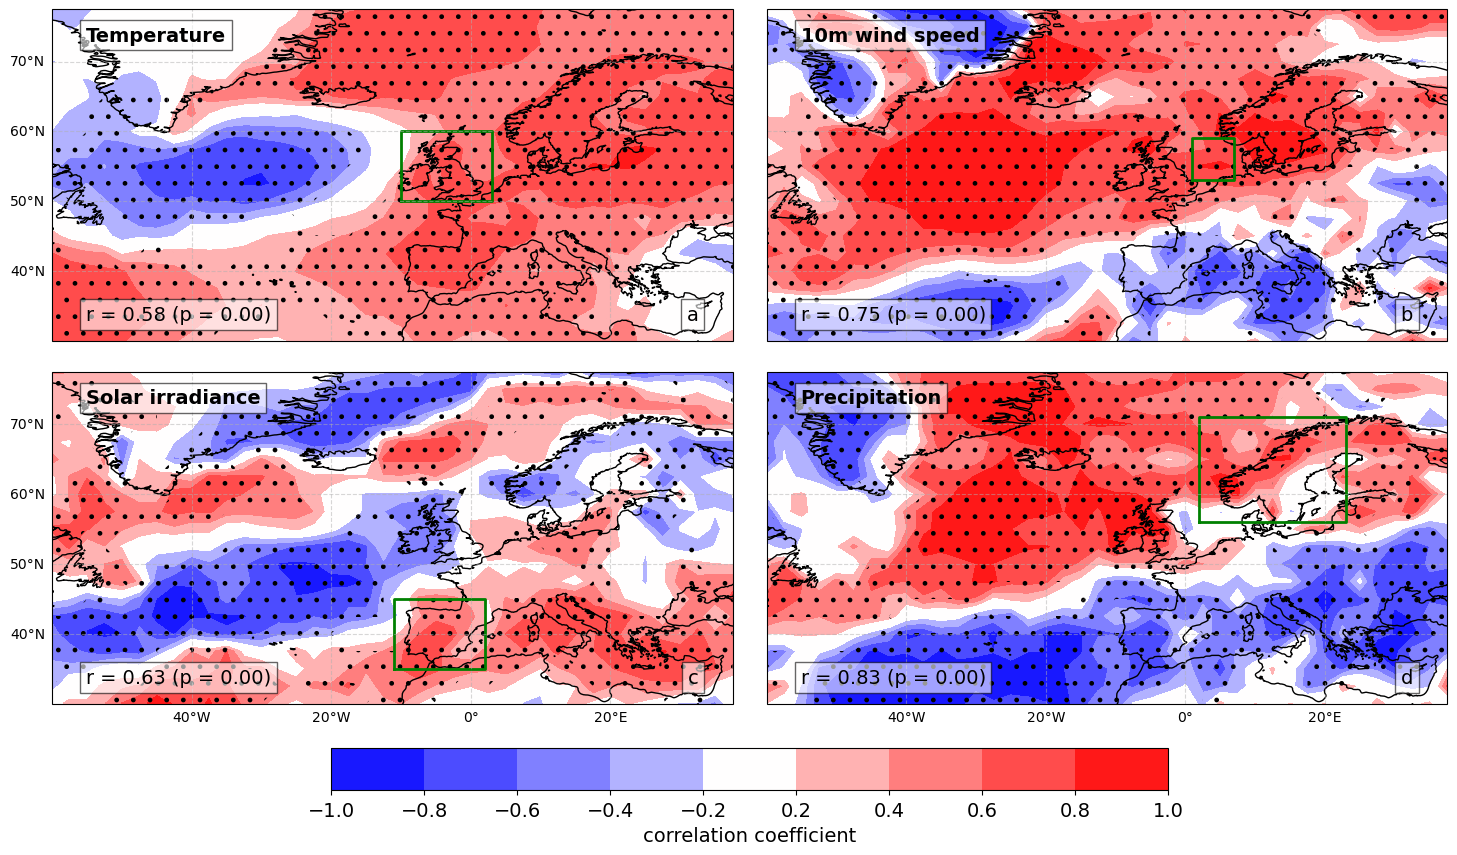

In [45]:
# Test the subplots functions
funcs_em.plot_corr_subplots(
    corr_arrays=corr_arrays,
    pval_arrays=pval_arrays,
    lats=stats_dict_tas["lats"],
    lons=stats_dict_tas["lons"],
    variables=variables,
    sig_threshold=0.05,
    plot_gridbox=plot_gridboxes,
    nao=stats_dict_tas["nao"],
    corr_var_ts=corr_var_ts,
    figsize_x_px=1800,
    figsize_y_px=1150,
    save_dpi=1000,
    fig_labels=fig_labels,
    fontsize=15,
    w_space=0.05,
    h_space=0.05,
)